## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from PIL import Image
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [2]:
# DATASET = 'affectnet'
DATASET = 'fer2013'
# DATASET = 'mma'
# DATASET = 'merged_dataset'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/fer2013/train/happy\Training_76501326.jpg,happy
1,input/fer2013/train/fear\PrivateTest_28573973.jpg,fear
2,input/fer2013/train/fear\Training_60462901.jpg,fear
3,input/fer2013/train/angry\Training_16844918.jpg,angry
4,input/fer2013/train/happy\Training_2190921.jpg,happy


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/fer2013/test/happy\PublicTest_8979920.jpg,happy
1,input/fer2013/test/fear\PrivateTest_3388910.jpg,fear
2,input/fer2013/test/sad\Training_10576214.jpg,sad
3,input/fer2013/test/angry\Training_39337132.jpg,angry
4,input/fer2013/test/disgust\PublicTest_82624961...,disgust


In [6]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/fer2013/valid/sad\Training_45125882.jpg,sad
1,input/fer2013/valid/happy\Training_11683181.jpg,happy
2,input/fer2013/valid/happy\Training_86775842.jpg,happy
3,input/fer2013/valid/neutral\PrivateTest_406515...,neutral
4,input/fer2013/valid/sad\Training_43427583.jpg,sad


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

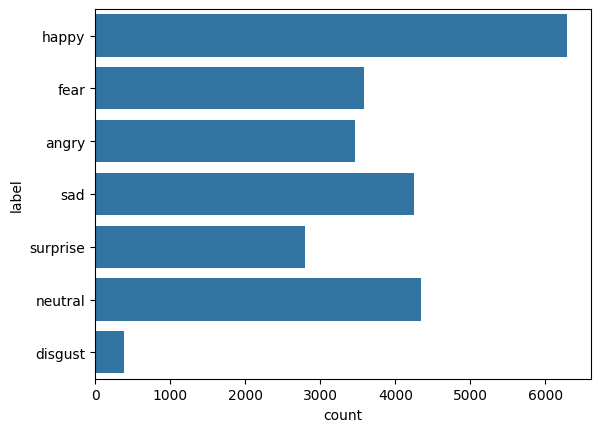

In [7]:
sns.countplot(train['label'])

## Grid of dataset images

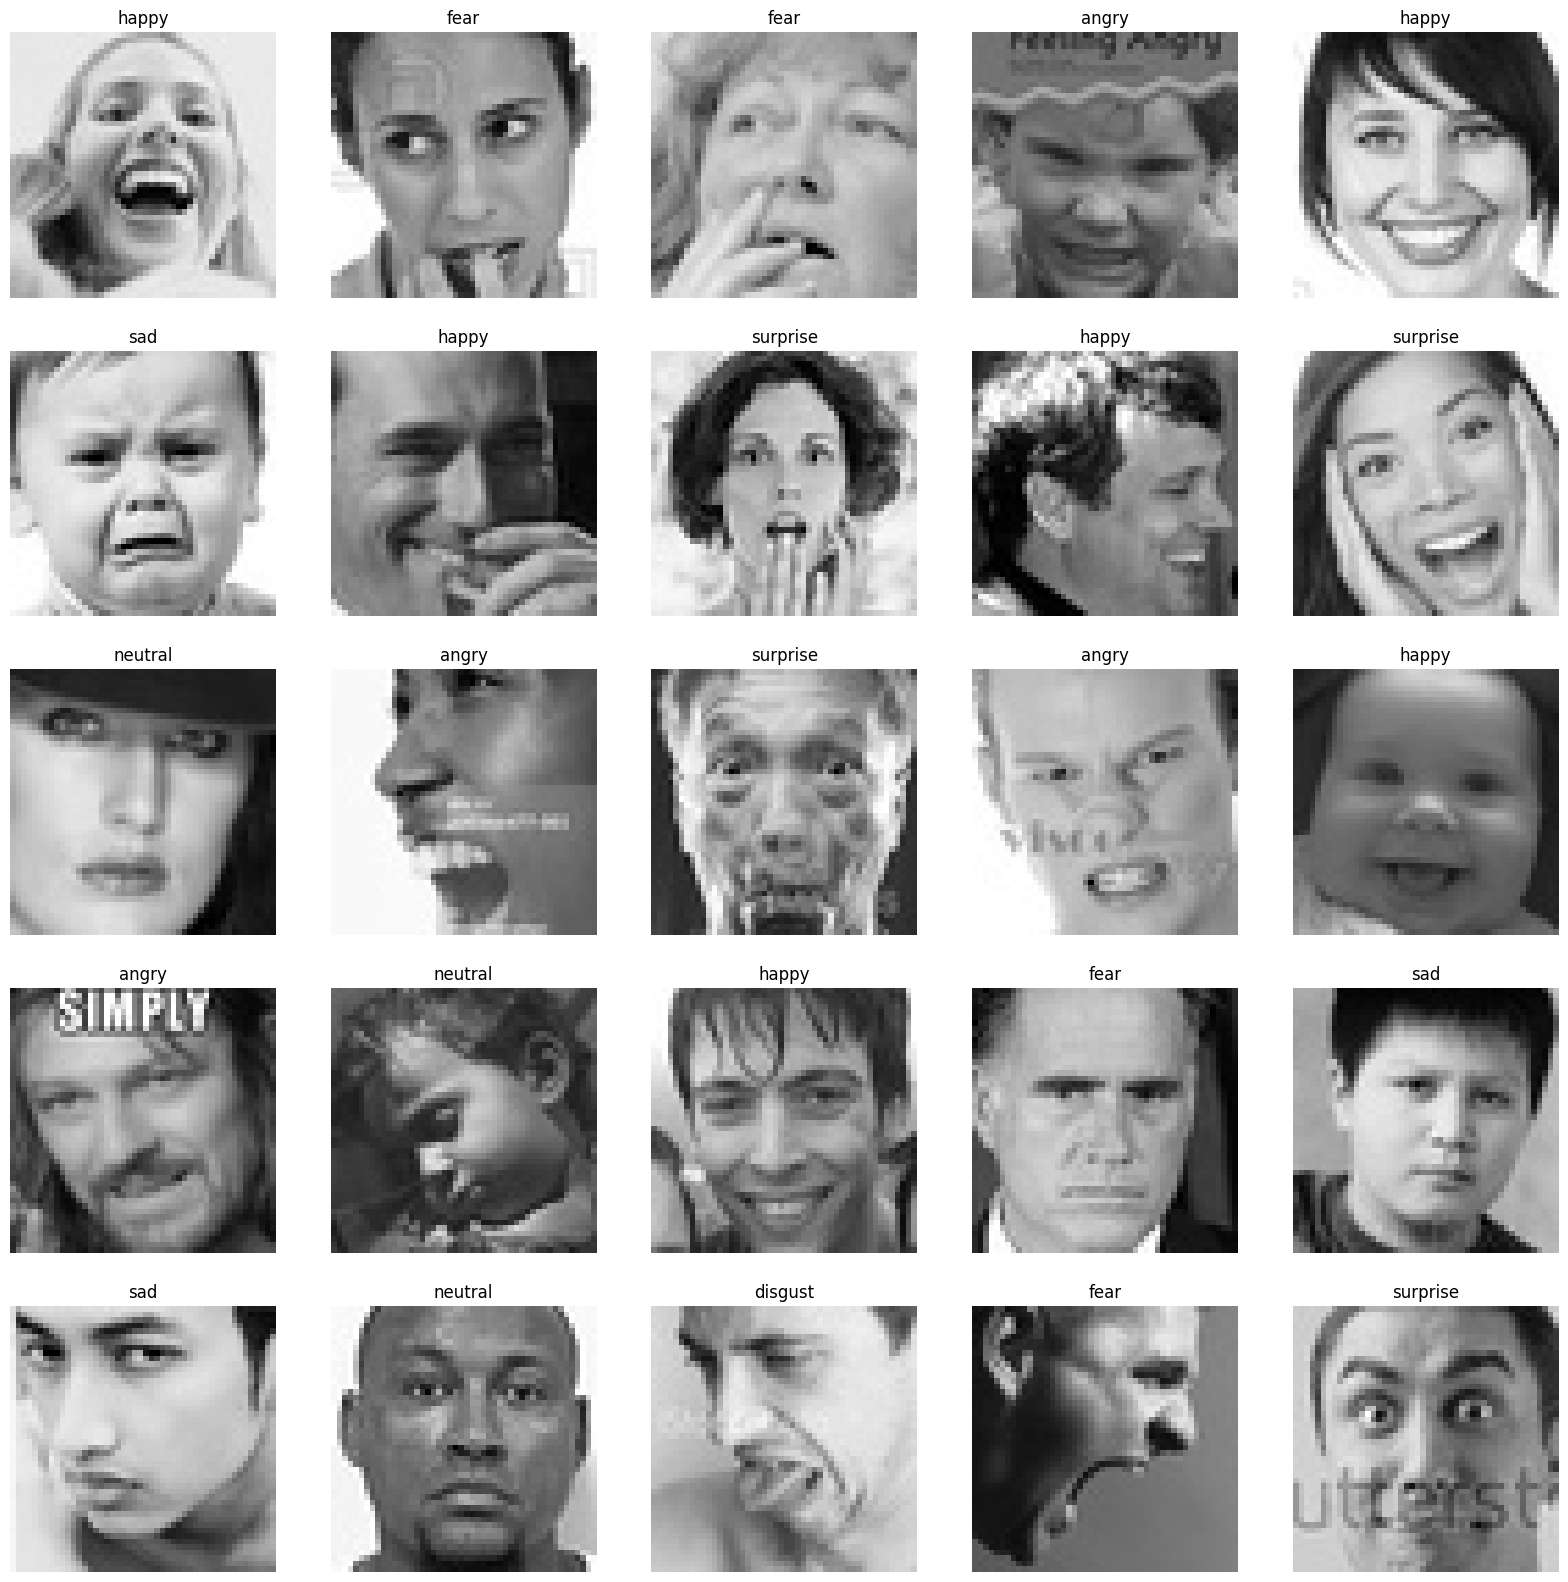

In [8]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET.startswith('affectnet'): # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [10]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/25117 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/3589 [00:00<?, ?it/s]

In [12]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/7181 [00:00<?, ?it/s]

In [13]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [15]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.])

In [16]:
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [17]:
# 5 layer model
model = Sequential(name='5-layer')

# convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fatten layer
model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# # 6 layer model
# model = Sequential(name='6-layer')

# # Convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# # global average pooling layer
# model.add(GlobalAveragePooling2D())

# # fully connected layers
# model.add(Dense(output_class, activation='softmax'))

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "5-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 1024)          │              

 Total params: 16,307,207 (62.21 MB)

 Trainable params: 16,299,783 (62.18 MB)

 Non-trainable params: 7,424 (29.00 KB)

## Train the model

In [19]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 306s 385ms/step - accuracy: 0.1923 - loss: 2.4399 - val_accuracy: 0.2672 - val_loss: 1.8321
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 289s 368ms/step - accuracy: 0.2991 - loss: 1.7585 - val_accuracy: 0.3487 - val_loss: 1.7566
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 288s 367ms/step - accuracy: 0.4564 - loss: 1.4230 - val_accuracy: 0.4245 - val_loss: 1.5650
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 291s 370ms/step - accuracy: 0.5069 - loss: 1.3036 - val_accuracy: 0.4930 - val_loss: 1.3762
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 288s 367ms/step - accuracy: 0.5323 - loss: 1.2248 - val_accuracy: 0.5336 - val_loss: 1.4211
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 286s 364ms/step - accuracy: 0.5590 - loss: 1.1564 - val_accuracy: 0.5246 - val_loss: 1.2668
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 285s 362ms/step - accuracy: 0.5926 - loss: 1.0941 - val_accuracy: 0.5391 - val_loss: 1.2253
Epoch 8/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 288s 367ms/step - accuracy: 

## Save the model

In [28]:
model.save(f'models/{model.name}_{DATASET}.keras')

## Plot the Results

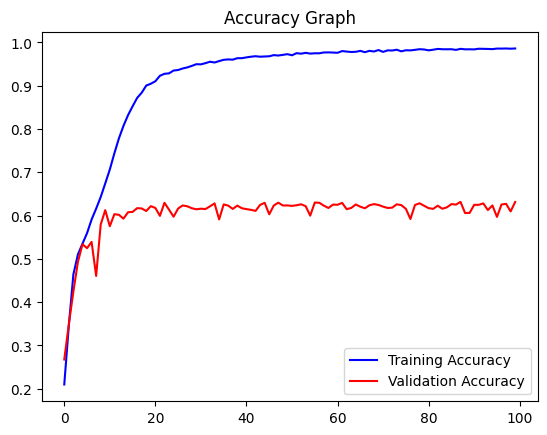

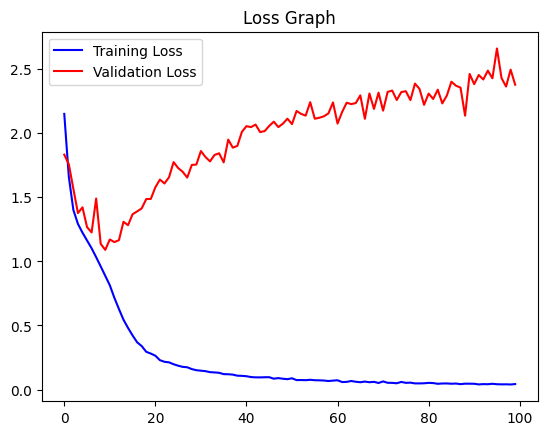

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.savefig(f'plots/AccuracyGraph_{model.name}_{DATASET}.png', bbox_inches='tight')
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.savefig(f'plots/LossGraph_{model.name}_{DATASET}.png', bbox_inches='tight')

## Accuracy, F1, Precision, Recall

In [38]:
from tensorflow.keras.models import load_model

# model = load_model('models/model.keras')

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step


In [39]:
y_pred = np.array([np.eye(len(row))[row.argmax()] for row in y_pred_prob])

In [40]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

       angry       0.52      0.53      0.52       495
     disgust       0.81      0.55      0.65        55
        fear       0.53      0.39      0.45       512
       happy       0.79      0.82      0.80       899
     neutral       0.58      0.50      0.54       620
         sad       0.43      0.56      0.48       608
    surprise       0.76      0.77      0.76       400

   micro avg       0.61      0.61      0.61      3589
   macro avg       0.63      0.59      0.60      3589
weighted avg       0.61      0.61      0.61      3589
 samples avg       0.61      0.61      0.61      3589



In [41]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(acc)

0.6082474226804123


## Confusion matrix

<Figure size 640x480 with 0 Axes>

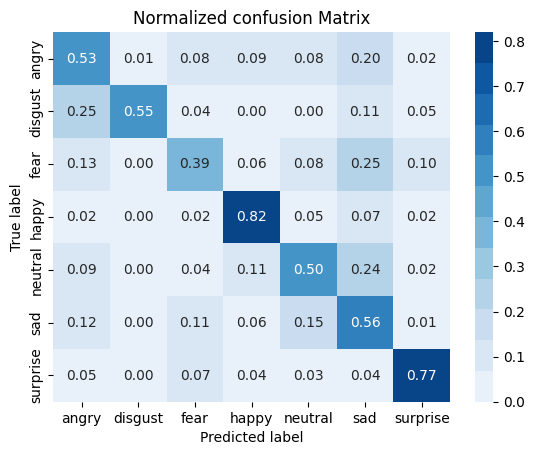

<Figure size 640x480 with 0 Axes>

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    le.inverse_transform(np.argmax(y_test, axis=1)),
    le.inverse_transform(np.argmax(y_pred, axis=1)),
    normalize='true'
)

sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap=sns.color_palette('Blues', 12),
    fmt='.2f'
)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Normalized confusion Matrix')
plt.savefig(f'plots/ConfusionMatrix_{model.name}_{DATASET}.png', bbox_inches='tight')
plt.figure()

## Test with Image Data

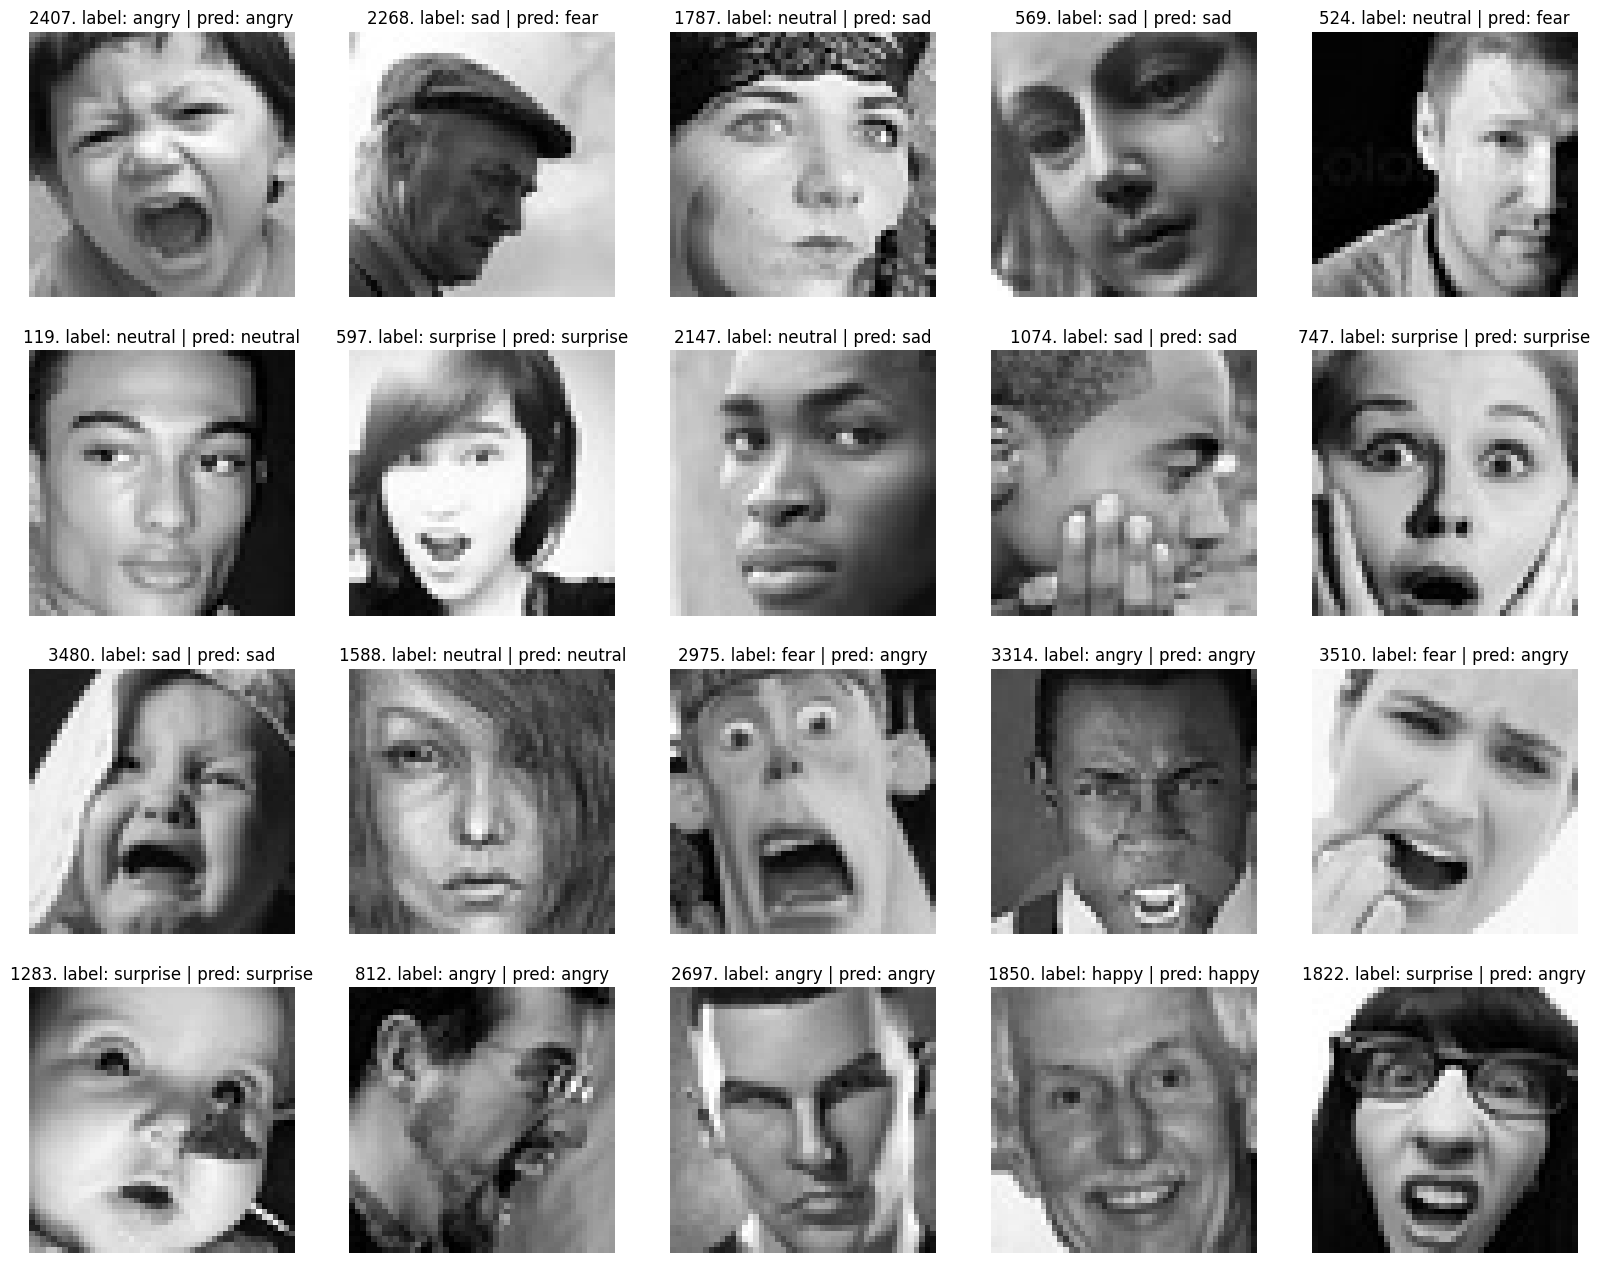

In [43]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')